In [82]:
import pandas as pd
import re

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [99]:
annotated_data = pd.read_csv('sample.csv')
annotated_data.head()

,TITLE,smartphone
0,Capa Samsung Galaxy S5 Mini Pc Couro Branco,0
1,Cabo Usb Retrátil 3 Adaptadores Preto - Muvit,0
2,Celular Samsung Galaxy A8 Plus 2018 Sm-a730f 6...,1
3,Lousa Magnética Grande Em Formato De Vaca Suelen,0
4,Aplique Madeira E Papel Placa Pinguim Com Colh...,0


In [101]:
patterns_re = [
    re.compile(r'smart', re.IGNORECASE), # contém "smart"
    re.compile(r'(?:ph|f)one', re.IGNORECASE), # contém "fone" ou "phone"
    re.compile(r'celular', re.IGNORECASE), # contém "celular"
    re.compile(r'\b[a-z]\d\b', re.IGNORECASE), # contém, p.e., "G5", "S9", ...
    re.compile(r'\bcapa\b', re.IGNORECASE), # contém "capa"
    re.compile(r'\bpara\b', re.IGNORECASE), # contém "para" (p.e. "antena para celular")
]

attr_names = ['smart', 'phone', 'celular', 'XN', 'capa', 'para']

In [102]:
def get_attributes(title):
    title_attributes = []
    for pattern in patterns_re:
        if pattern.search(title) is None:
            title_attributes.append(0)
        else:
            title_attributes.append(1)
    return title_attributes

In [103]:
attributes = []
for i in annotated_data.index:
    row_attr = get_attributes(annotated_data.loc[i].TITLE)
    attributes.append(row_attr)
annotated_attributes = pd.DataFrame(attributes)
annotated_attributes.columns = attr_names
annotated_attributes.insert(0, 'TITLE', annotated_data.TITLE)
annotated_attributes['smartphone'] = annotated_data.smartphone

annotated_attributes.sample(10)

,TITLE,smart,phone,celular,XN,capa,para,smartphone
231,Cinta Elástica Lombar Salvapé Lite 161 Lt,0,0,0,0,0,0,0
151,Aplique Madeira E Papel 3d Jacaré Marinheiro L...,0,0,0,0,0,0,0
393,Preta Gil Esmalte Cremoso Cinza Luxo 9ml,0,0,0,0,0,0,0
6,Tinta Para Hp Universal High Definition Aton B...,0,0,0,0,0,1,0
122,Carretilha Marine Sports Caster 200 (Manivela ...,0,0,0,0,0,0,0
186,Apple Iphone 8 Plus 64gb Novo Lacrado 1 Ano Ga...,0,1,0,0,0,0,1
496,Pulseira Masculina Feminina Lava Vulcância Cru...,0,0,0,0,0,0,0
431,Capa para Vade Mecum com Alça de Ombro Veneza,0,0,0,0,1,1,0
460,Omnitrix Touch Omniverse Nova Versão - Sunny 654,0,0,0,0,0,0,0
401,Papel Decoupage Flores Roxas Ld-797 - Litocart,0,0,0,0,0,0,0


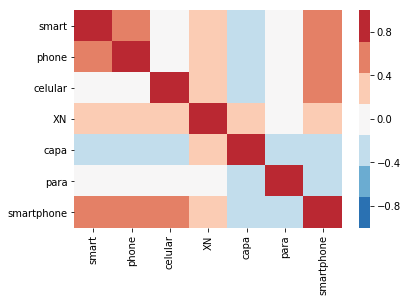

In [83]:
sns.heatmap(annotated_attributes.corr(), vmin=-1, vmax=+1, cmap=sns.color_palette("RdBu_r", 7))
plt.show()

In [85]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import cross_val_score

In [92]:
perceptron = Perceptron(max_iter=1e3)
roc_auc = cross_val_score(
    perceptron,
    annotated_attributes.iloc[:, 1:7].values,
    annotated_attributes.iloc[:, 7].values,
    scoring='roc_auc',
    cv=10
)

In [93]:
roc_auc

array([0.98333333, 0.98      , 0.97333333, 1.        , 1.        ,
       1.        , 0.92666667, 1.        , 0.98      , 0.94285714])